# Tutorial 2: Escalamiento y transformaciones de imágenes

En este tutorial desarrollaremos implementaciones que nos permitirán cambiar las dimensiones de una imagen, su distribución geométrica y su distribución de intensidades. Además, estudiaremos a las imágenes como arreglos matriciales cuyos elementos corresponden a intensidades discretizadas, y comentaremos acerca del rol de las transformaciones de imágenes en el desarrollo de modelos.

In [1]:
# librerías necesarias

import numpy as np # NumPy para operaciones numéricas
from skimage.io import imread # skimage para leer imágenes
import matplotlib.pyplot as plt # Matplotlib para visualización
import math # Math para operaciones matemáticas
import cv2 # OpenCV para procesamiento de imágenes

## Escalamiento de imágenes

Cambiar las dimensiones de una imagen es un proceso crucial en el análisis y procesamiento de imágenes, ya sea porque se quiere editar su visualización, ajustarla a un tamaño requerido como entrada a un modelo, hacer un aumento de datos o emplear esta técnica con el fin de efectuar algún tipo de procesamiento del ruido.

Los procesos de reducir y aumentar las dimensiones de una imagen siguen fundamentos distintos. Al reducir las dimensiones, la nueva representación matricial de la imagen tiene menos elementos de los que había originalmente, por lo que se debe hacer una selección de algunas intensidades representativas de la imagen original. Esto conlleva una pérdida de información. Por otro lado, al aumentar las dimensiones, la nueva representación matricial tendrá más elementos de los que había originalmente, por lo que a estos se les deberá asignar intensidades basadas en el contexto de la imagen original. Esta adición de información que no corresponde precisamente a aquello representado en una primera instancia puede introducir artefactos en la visualización.

### Reducción de dimensiones

Una de las formas de reducir las dimensiones de una imagen es *submuestrear* intensidades distribuidas de forma homogénea. En otras palabras, esto corresponde a que la nueva representación matricial esté compuesta de elementos de la imagen original separados por un determinado número de filas y columnas.

In [10]:
# Se define la función:

# El parámetro image corresponde a una imagen de un canal (escala de grises) representada
# por una matriz de dimensiones n x m (filas x columnas)

# El parámetro dim correponde a las nuevas dimensiones deseadas, una tupla (nueva cantidad de filas y nueva cantidad de columnas)

def resize_subsample(image, dim):
    
    # Se definen las variables n, m, a y b según se describieron los parámetros de la función
    (n, m) = image.shape
    a, b = dim
    
    # Se inicializa la imagen escalada como una matriz de ceros con las dimensiones ingresadas como parámetro
    resized_image = np.zeros(dim)
    
    # Se define la distancia entre píxeles que se va a tomar vertical y horizontalmente (factor de escala)
    step_n = n / a
    step_m = m / b
    
    # Se asignan las intensidades de la imagen escalada a partir de submuestrear píxeles en de la imagen
    # original con una separación de aproximadamente step_n píxeles verticales y y step_m píxeles horizontales
    for i in range(a):
        for j in range(b):
            resized_image[i,j] = image[round(step_n * i), round(step_m * j)]
    return resized_image

In [9]:
original_image = imread('rose.png', as_gray = True)
resize_image= resize_subsample(original_image,(400,400))
assert (resize_image.shape==(400,400))
assert (np.sum(resize_image)==7481907.0)

### Aumento de dimensiones

Al aumentar las dimensiones de una imagen, para determinar las intensidades asociadas a los elementos que no provienen de la imagen original se suele usar la *interpolación*, la cual es un proceso que consiste en asignar una intensidad resultante de un promedio ponderado de las intensidades originales locales. Una de las interpolaciones más simples es la interpolación bilineal, la cual corresponde a un promedio ponderado en el que se tienen en cuenta las intensidades de los 4 pixeles originales más cercanos y sus pesos asociados aumentan entre más cerca se está a dichos píxeles. A continuación, se presenta una representación gráfica de un ejemplo de interpolación bilineal:

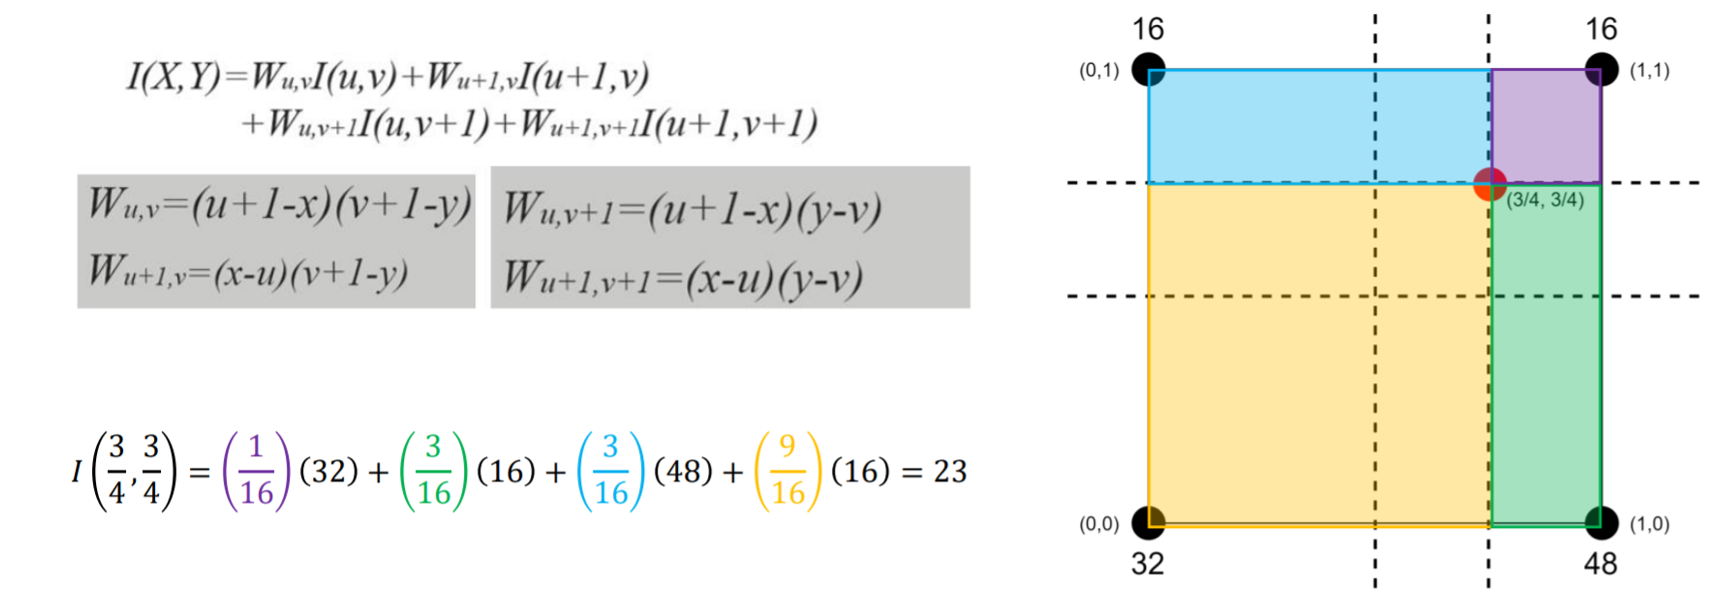

En este caso $I(i, j)$ e $W(i, j)$ corresponden a la intensidad y el peso asociado al píxel en la coordenada $(i, j)$ en el promedio ponderado de la interpolación bilineal. Gráficamente podemos identificar que los pesos son equivalentes al área de los 4 rectángulos que se forman al partir la región de interpolación empleando los 4 píxeles originales y la coordenada a interpolar como vértices. A continuación, se presentará la implementación de una función que emplea la interpolación bilineal para aumentar las dimensiones de una imagen de forma arbitraria a partir de unas nuevas dimensiones ingresadas como parámetro:

In [11]:
# Se define la función:

# El parámetro image corresponde a una imagen de un canal (escala de grises) representada
# por una matriz de dimensiones n x m (filas x columnas)

# El parámetro dim correponde a las nuevas dimensiones deseadas, una tupla (nueva cantidad de filas y nueva cantidad de columnas)

def resize_interpolation(image, dim):
    
    # Se definen las variables n, m, a y b según se describieron los parámetros de la función
    (n, m) = image.shape
    a,b = dim

    # Se inicializa la imagen escalada como una matriz de ceros con las dimensiones ingresadas como parámetro
    resized_image = np.zeros(dim)
    
    # Se calcula el factor de escala.
    step_n = n / a
    step_m = m / b
    
    for i in range(a):
        for j in range(b):
            
            # Mapeamos las coordenadas de la imagen escalada (i, j) a coordenadas en la escala de la imagen original (x, y)
            x, y = i * step_n, j * step_m
            
            # Encontramos las coordenadas de los 4 pixeles que corresponde a los vertices de la interpolación
            x_floor = math.floor(x)
            x_ceil = min(n - 1, math.ceil(x))
            y_floor = math.floor(y)
            y_ceil = min(m - 1, math.ceil(y))
            
            # Caso en el que el pixel a considerar es uno de los vértices
            if (x_floor == x_ceil) and (y_floor == y_ceil):
                resized_image[i,j] = image[int(x), int(y)]
            
            # Caso en el que el pixel a considerar se encuentra en una arista vertical
            elif x_floor == x_ceil:
                I1 = image[int(x), y_floor]
                I2 = image[int(x), y_ceil]
                resized_image[i,j] = (y - y_floor) * I1 + (y_ceil - y) * I2
            
            # Caso en el que el pixel a considerar se encuentra en una arista horizontal
            elif y_floor == y_ceil:
                I1 = image[x_floor, int(y)]
                I2 = image[x_ceil, int(y)]
                resized_image[i,j] = (x - x_floor) * I1 + (x_ceil - x) * I2
            
            # Caso general de interpolación bilineal
            else:
            
                # Obtenemos la intensidad de los vertices
                I1 = image[x_floor, y_floor]
                I2 = image[x_ceil, y_floor]
                I3 = image[x_floor, y_ceil]
                I4 = image[x_ceil, y_ceil]

                # Obtenemos los pesos de cada vértice a partir de las coordenadas
                W1 = (x - x_floor) * (y - y_floor)
                W2 = (x_ceil - x) * (y - y_floor)
                W3 = (x - x_floor) * (y_ceil - y)
                W4 = (x_ceil - x) * (y_ceil - y)

                # Aplicamos el promedio ponderado de la interpolación bilineal para asignar la intensidad de la imagen escalada
                resized_image[i,j] = W1 * I1 + W2 * I2 + W3 * I3 + W4 * I4
    
    # Se retorna la imagen escalada
    return resized_image

A continuación, se presentan los resultados de aumentar y reducir las dimensiones de una imagen a blanco y negro empleando las funciones previamente implementadas. Debido al tamaño de la imagen original y la implementación propuesta de la interpolación bilineal el código puede demorarse un poco en correr.

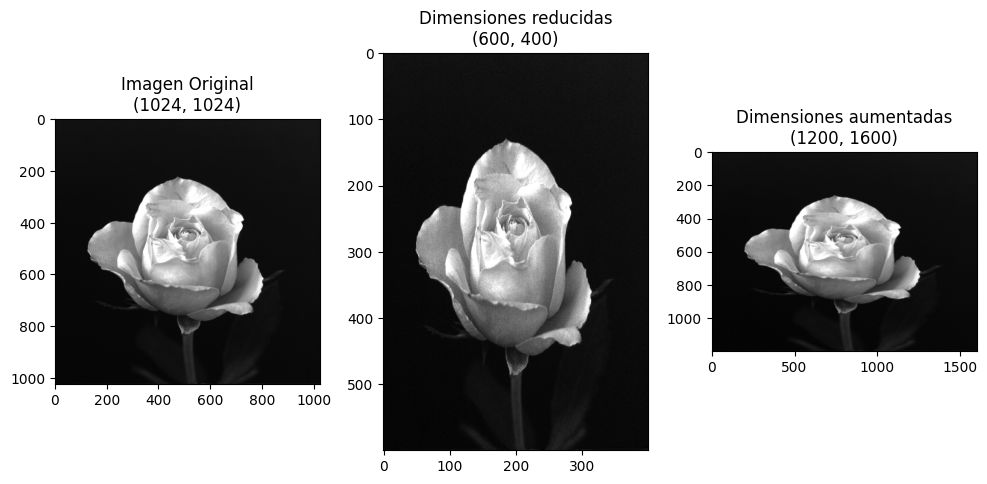

In [12]:
original_image = imread('rose.png', as_gray = True)

plt.figure(figsize=(10,8))

plt.subplot(131)
plt.title('Imagen Original\n' + str(original_image.shape))
plt.imshow(original_image, cmap = 'gray')

plt.subplot(132)
plt.title('Dimensiones reducidas\n(600, 400)')
plt.imshow(resize_subsample(original_image, (600, 400)), cmap = 'gray')

plt.subplot(133)
plt.title('Dimensiones aumentadas\n(1200, 1600)')
plt.imshow(resize_interpolation(original_image, (1200, 1600)), cmap = 'gray')

plt.tight_layout()

Ahora, se mostrará el mismo proceso mediante la libreria cv2: 

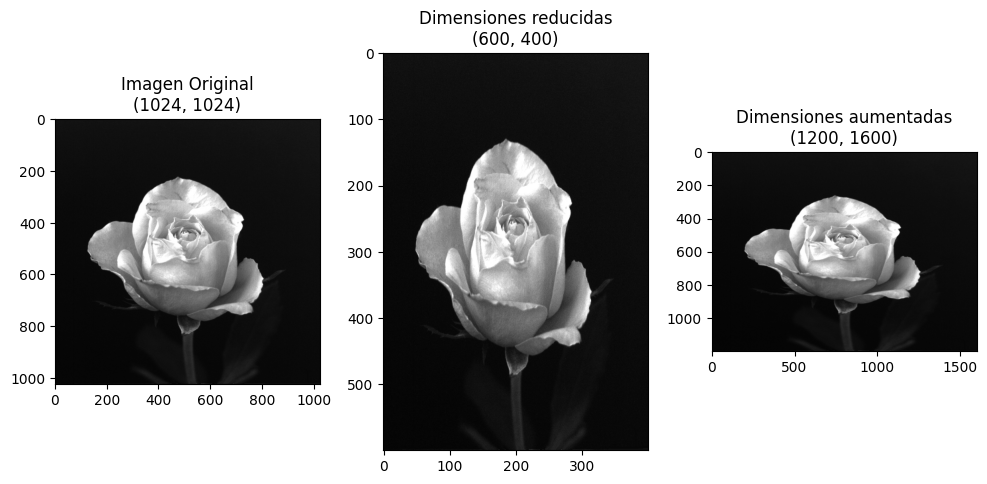

In [13]:
original_image = imread('rose.png', as_gray = True)

reduce_image = cv2.resize(original_image, (400, 600))

bilin_image = cv2.resize(original_image, (1600, 1200), interpolation=cv2.INTER_LINEAR)

plt.figure(figsize=(10,8))

plt.subplot(131)
plt.title('Imagen Original\n' + str(original_image.shape))
plt.imshow(original_image, cmap = 'gray')

plt.subplot(132)
plt.title('Dimensiones reducidas\n(600, 400)')
plt.imshow(reduce_image, cmap = 'gray')

plt.subplot(133)
plt.title('Dimensiones aumentadas\n(1200, 1600)')
plt.imshow(bilin_image, cmap = 'gray')

plt.tight_layout()

## Ejercicio 1:
Ahora, realicemos una comparación entre este método y el método de vecino más cercano. Para eso, tendrán que implementar la función de interpolación de vecino más cercano. Los parámetros de la función serán una imagen con 3 canales RGB y las dimensiones que queremos para la imagen.

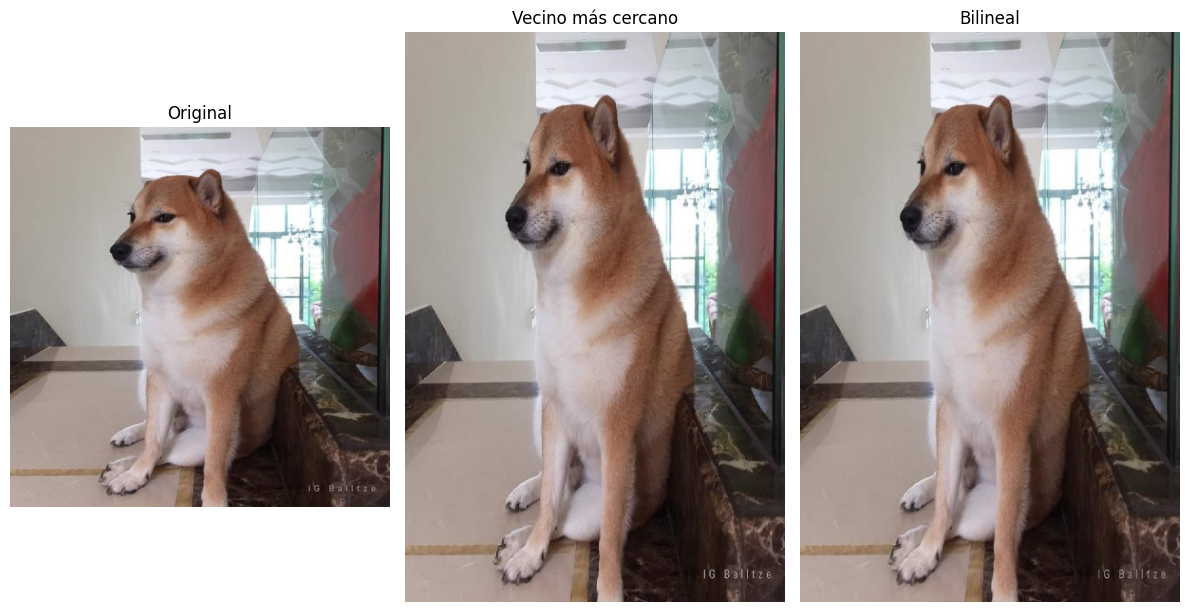

In [16]:
# Resize con cv2 usando interpolación de vecino más cercano (INTER_NEAREST) y comparación con bilineal
original_image = imread('Perro.jpg')
# Si la imagen está en float [0,1], conviértela a uint8 [0,255]
if original_image.max() <= 1.0:
    original_image = (original_image * 255).astype(np.uint8)

# Redimensionar a 600x400 con vecino más cercano
resize_nearest = cv2.resize(original_image, (400, 600), interpolation=cv2.INTER_NEAREST)

# Redimensionar a 600x400 con bilineal
resize_bilinear = cv2.resize(original_image, (400, 600), interpolation=cv2.INTER_LINEAR)

plt.figure(figsize=(12,6))
plt.subplot(131)
plt.title('Original')
plt.imshow(original_image)
plt.axis('off')

plt.subplot(132)
plt.title('Vecino más cercano')
plt.imshow(resize_nearest)
plt.axis('off')

plt.subplot(133)
plt.title('Bilineal')
plt.imshow(resize_bilinear)
plt.axis('off')

plt.tight_layout()

In [ ]:
def resize_interpolation_RGB(image, dim):
    
    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)

    # Se definen las variables n, m, a y b según se describieron los parámetros de la función
    (n, m, c) = image.shape
    a, b = dim

    # Se inicializa la imagen escalada como una matriz de ceros con las dimensiones ingresadas como parámetro
    resized_image = np.zeros((a, b, c), dtype = np.uint8)
    
    # Se calcula el factor de escala.
    step_n = n / a
    step_m = m / b
    
    for i in range(a):
        for j in range(b):
            orig_i = int(round(i * step_n)) #encontrar posicion cercana a la original
            orig_j = int(round(j * step_m))

            orig_i = min(orig_i, n - 1) #son como rangos
            orig_j = min(orig_j, m - 1)

            resized_image[i, j] = image[orig_i, orig_j]
    
    return resized_image

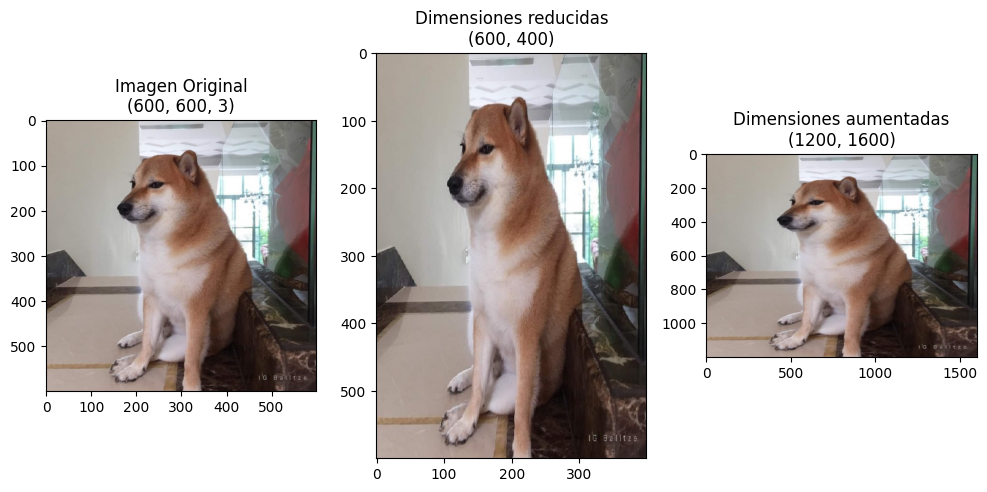

In [26]:
original_image = imread('Perro.jpg')

plt.figure(figsize=(10,8))

plt.subplot(131)
plt.title('Imagen Original\n' + str(original_image.shape))
plt.imshow(original_image, cmap = 'gray')

plt.subplot(132)
plt.title('Dimensiones reducidas\n(600, 400)')
plt.imshow(resize_interpolation_RGB(original_image, (600, 400)), cmap = 'gray')

plt.subplot(133)
plt.title('Dimensiones aumentadas\n(1200, 1600)')
plt.imshow(resize_interpolation_RGB(original_image, (1200, 1600)), cmap = 'gray')

plt.tight_layout()

In [27]:
original_image = imread('Perro.jpg')
resize_image= resize_interpolation_RGB(original_image, (600, 400))
assert (resize_image.shape==(600, 400,3)), f'Su imagen no tiene las nuevas dimensiones 600x400x3 sino {resize_image.shape}'
assert np.isclose(np.sum(resize_image), 94891712, 0.01), 'la imagen con la nueva dimensión es erronea'

Ahora se realizará usando la libreria cv2 como una alternativa de rapido procesamiento cuando se necesita repetir muchas veces:

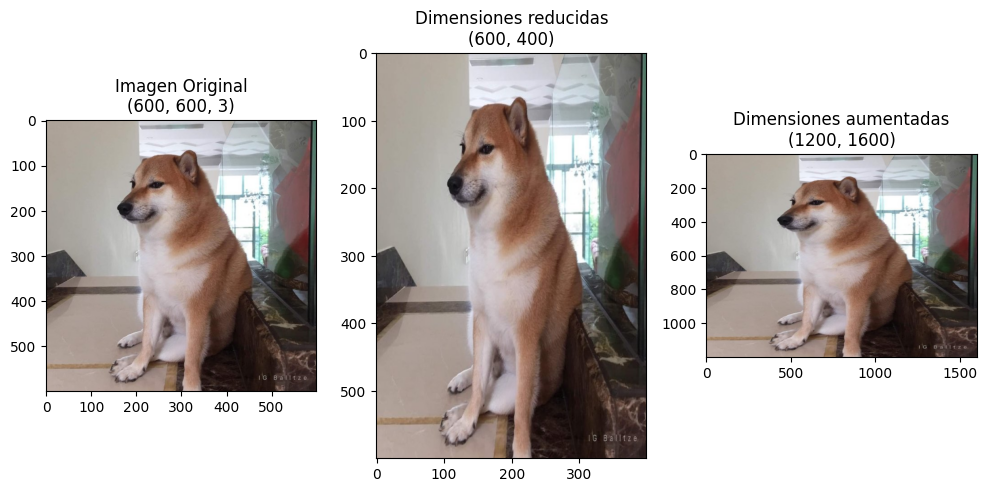

In [28]:
original_image = imread('Perro.jpg')

reduce_image = cv2.resize(original_image, (400, 600))

near_image = cv2.resize(original_image, (1600, 1200), interpolation=cv2.INTER_NEAREST)

plt.figure(figsize=(10,8))

plt.subplot(131)
plt.title('Imagen Original\n' + str(original_image.shape))
plt.imshow(original_image, cmap = 'gray')

plt.subplot(132)
plt.title('Dimensiones reducidas\n(600, 400)')
plt.imshow(reduce_image, cmap = 'gray')

plt.subplot(133)
plt.title('Dimensiones aumentadas\n(1200, 1600)')
plt.imshow(near_image, cmap = 'gray')

plt.tight_layout()

## Transformaciones geométricas

Las *transformaciones geométricas* son funciones que mapean cada píxel (cuyas coordenadas podemos denotar como $(x, y)$) a una nueva posición $(x', y')$. Un subconjunto se estas transformaciones son las *transformaciones afines*, en las cuales las nuevas coordenadas se pueden expresar como una combinación lineal de las coordenadas originales:

\begin{equation}
x' = ax + by + m
\end{equation}
\begin{equation}
y' = cx + dy + n
\end{equation}

Estas transformaciones afines se pueden realizar aplicando un producto matricial entre una matriz de transformación y un vector asociado a las coordenadas de cada píxel, tal como se ha explicado en el curso.

A continuación, tiene una función que genera una transformación unica indicada (no secuencial) Note que lo importante de la implementación es la matriz. Tomese el trabajo de entender la función que se le preporciona.

In [ ]:
def transformacion(image, t,s,angulo):
    
    # Se define la traslación en x y y según la descripción de los parámetros y se crea una matriz de transformación
    if t !=0:
        tx, ty = t #t son dos valores, que son como cuanto se translada en x y en y
        T = np.array([[1, 0, tx],
                    [0, 1, ty],
                    [0, 0, 1]])
    elif s !=0:
        sh, sv = s #sh es cizalla horizontal, sv es cizalla vertical
        T = np.array([[1, sh, 0],
                    [sv, 1, 0],
                    [0, 0, 1]])
    elif angulo!=0: # rotacion
        T = np.array([[np.cos(angulo), -np.sin(angulo), 0],
                  [np.sin(angulo), np.cos(angulo), 0],
                  [0, 0, 1]])
    # Se inicializa la imagen trasladada como un arreglo de ceros de dimensiones iguales a la imagen original
    translated_image = np.zeros(image.shape)
    
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            # Para cada píxel de la imagen original se aplica la multiplicación matricial asociada a la
            # transformación para obtener las nuevas coordenadas
            X = np.array([x, y, 1]).T #multiplicacion matricial
            X_prime = np.matmul(T, X)
            x_prime, y_prime, _ = X_prime
            x_prime=int(x_prime)
            y_prime=int(y_prime)
            # Las intensidades asociadas a las coordenadas que se encuentran dentro de los límites dados
            # por las dimensiones originales son almacenadas en el arreglo a retornar
            if 0 <= x_prime < image.shape[0] and 0 <= y_prime < image.shape[1]:
                translated_image[x_prime, y_prime] = image[x, y]
    
    # Se retorna la imagen trasladada
    return translated_image

A continuación, se presenta una visualización de una imagen de una tortuga y las imágenes resultantes de traslacion, share y rotación.

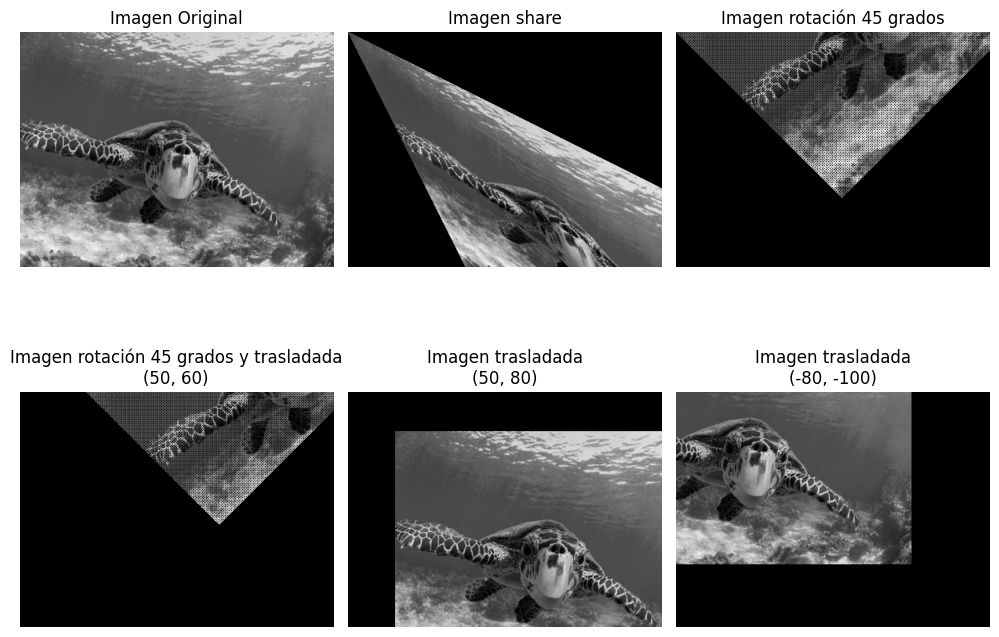

In [38]:
original_image = imread('turtle.jpg', as_gray = True)

plt.figure(figsize=(10,8))

plt.subplot(231)
plt.title('Imagen Original')
plt.imshow(original_image, cmap = 'gray')
plt.axis('off')

plt.subplot(232)
plt.title('Imagen share')
plt.imshow(transformacion(original_image,0, (0.5,0.5),0), cmap = 'gray')
plt.axis('off')

plt.subplot(233)
plt.title('Imagen rotación 45 grados')
plt.imshow(transformacion(original_image,0,0,np.pi/4), cmap = 'gray')
plt.axis('off')

plt.subplot(234)
plt.title('Imagen rotación 45 grados y trasladada\n(50, 60)')
plt.imshow(transformacion(transformacion(original_image,(50, 60),0,0), 0, 0, np.pi/4), cmap = 'gray')
plt.axis('off')

plt.subplot(235)
plt.title('Imagen trasladada\n(50, 80)')
plt.imshow(transformacion(original_image, (50, 60), 0, 0), cmap = 'gray')
plt.axis('off')

plt.subplot(236)
plt.title('Imagen trasladada\n(-80, -100)')
plt.imshow(transformacion(original_image, (-80, -100), 0, 0), cmap = 'gray')
plt.axis('off')

plt.tight_layout()

Ahora, haremos una función que realize las transformaciones de forma secuencial, es decir, utilizando la composición de transformaciones geométricas.

In [39]:
def transformacion_sequence(image, sequence,t,s,angulo):
    'squence (tuple): Una tupla de strings, los strings pueden ser "t","a" o "s" siendo translación, angulo y share respectivamente'
    # Se define la traslación en x y y según la descripción de los parámetros y se crea una matriz de transformación
    T=np.identity(3)

    # Se recorre sobre la sequiencia de transformaciones y se van agregando a una matriz de transformación global
    # Mediante multiplicación matricial.
    for i in sequence:
        if i=='a':
            T_aux = np.array([[np.cos(angulo), -np.sin(angulo), 0],
                      [np.sin(angulo), np.cos(angulo), 0],
                      [0, 0, 1]])
            T=np.matmul(T_aux,T)
        elif i=='t':
            tx, ty = t
            T_aux = np.array([[1, 0, tx],
                      [0, 1, ty],
                      [0, 0, 1]])
            T=np.matmul(T_aux,T)
        elif i=='s':
            sh, sv = s
            T_aux = np.array([[1, sh, 0],
                      [sv, 1, 0],
                      [0, 0, 1]])
            T=np.matmul(T_aux,T)
    # Se inicializa la imagen trasladada como un arreglo de ceros de dimensiones iguales a la imagen original
    translated_image = np.zeros(image.shape)
    
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            
            # Para cada píxel de la imagen original se aplica la multiplicación matricial asociada a la
            # transformación para obtener las nuevas coordenadas
            X = np.array([x, y, 1]).T
            X_prime = np.matmul(T, X)
            x_prime, y_prime, _ = X_prime
            x_prime=int(x_prime)
            y_prime=int(y_prime)
            # Las intensidades asociadas a las coordenadas que se encuentran dentro de los límites dados
            # por las dimensiones originales son almacenadas en el arreglo a retornar
            if 0 <= x_prime < image.shape[0] and 0 <= y_prime < image.shape[1]:
                translated_image[x_prime, y_prime] = image[x, y]
    
    # Se retorna la imagen trasladada
    return translated_image

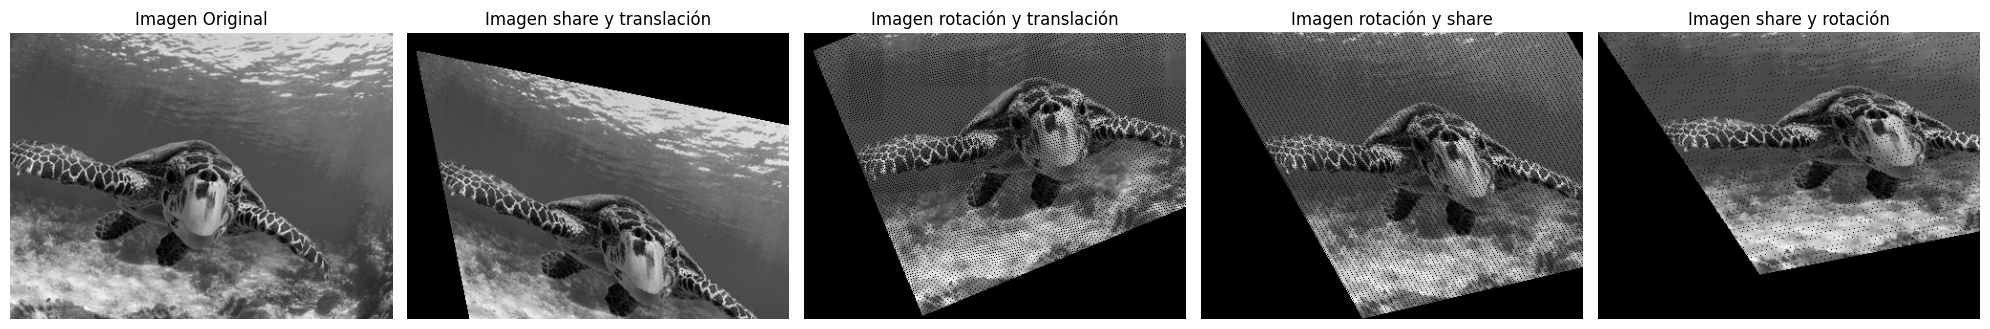

In [41]:
original_image = imread('turtle.jpg', as_gray = True)

plt.figure(figsize=(20,8))

plt.subplot(151)
plt.title('Imagen Original')
plt.imshow(original_image, cmap = 'gray')
plt.axis('off')

plt.subplot(152)
plt.title('Imagen share y translación')
transform_s_t=transformacion_sequence(original_image,('s','t'),(20,10), (0.2,0.2),0)
plt.imshow(transform_s_t, cmap = 'gray')
plt.axis('off')

plt.subplot(153)
plt.title('Imagen rotación y translación')
transform_a_t=transformacion_sequence(original_image,('a','t'),(20,10),0,np.pi/8)
plt.imshow(transform_a_t, cmap = 'gray')
plt.axis('off')

plt.subplot(154)
plt.title('Imagen rotación y share')
transform_a_s=transformacion_sequence(original_image,('a','s'),0,(0.2,0.2),np.pi/8)
plt.imshow(transform_a_s, cmap = 'gray')
plt.axis('off')

plt.subplot(155)
plt.title('Imagen share y rotación')
transform_s_a=transformacion_sequence(original_image,('s','a'),0,(0.2,0.2),np.pi/8)
plt.imshow(transform_s_a, cmap = 'gray')
plt.axis('off')

plt.tight_layout()

In [42]:
assert np.isclose(np.sum(transform_s_t-transformacion(transformacion(original_image,0,(0.2,0.2),0),(20,10),0,0)),0), 'Su secuencia de transformaciones por función no es igual a la secuencia de transformaciones de forma independiente'
assert np.sum(transform_a_t-transformacion(transformacion(original_image,0,0,np.pi/8),(20,10),0,0))!=0, 'Usted uso la función dada de forma iterativa'
assert np.sum(transform_a_s-transform_s_a)!=0, 'Su secuencia de rotacion-share deberia ser diferente a share-rotacion'
assert np.isclose(np.sum(transform_s_a==0),47274), 'Su implementación es erronea'

Como podemos ver en una de las verificaciones que hacemos anteriormente (asserts) la transformación mediante composición de transformaciones geométricas no es igual a cuando usamos la función de forma iterativa. Veamos esto graficamente:

(np.float64(-0.5), np.float64(399.5), np.float64(299.5), np.float64(-0.5))

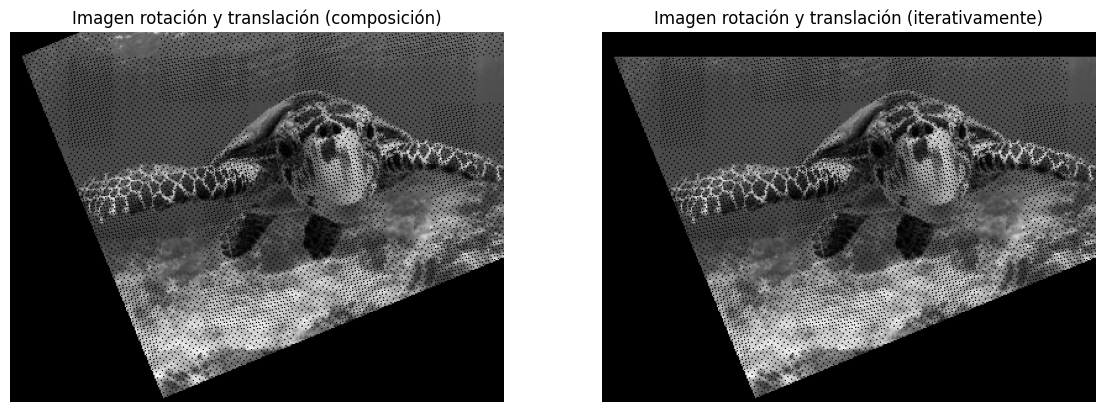

In [43]:
plt.figure(figsize = (14, 10))

plt.subplot(121)
plt.title('Imagen rotación y translación (composición)')
plt.imshow(transform_a_t, cmap = 'gray')
plt.axis('off')

plt.subplot(122)
plt.title('Imagen rotación y translación (iterativamente)')
plt.imshow(transformacion(transformacion(original_image,0,0,np.pi/8),(20,10),0,0), cmap = 'gray')
plt.axis('off')

Las diferencias que observamos son debido a que la función iterativa descarta cierta parte de la información al realizar la primera transformación, mientras que la composición de transformaciones utiliza toda la información. 

Aunque este metodo permite entender el paso a paso de estas transformaciones, puede no ser muy optimo. Por ende, a continuacion se presenta una implementacion de las 3 transformaciones con la libreria cv2:

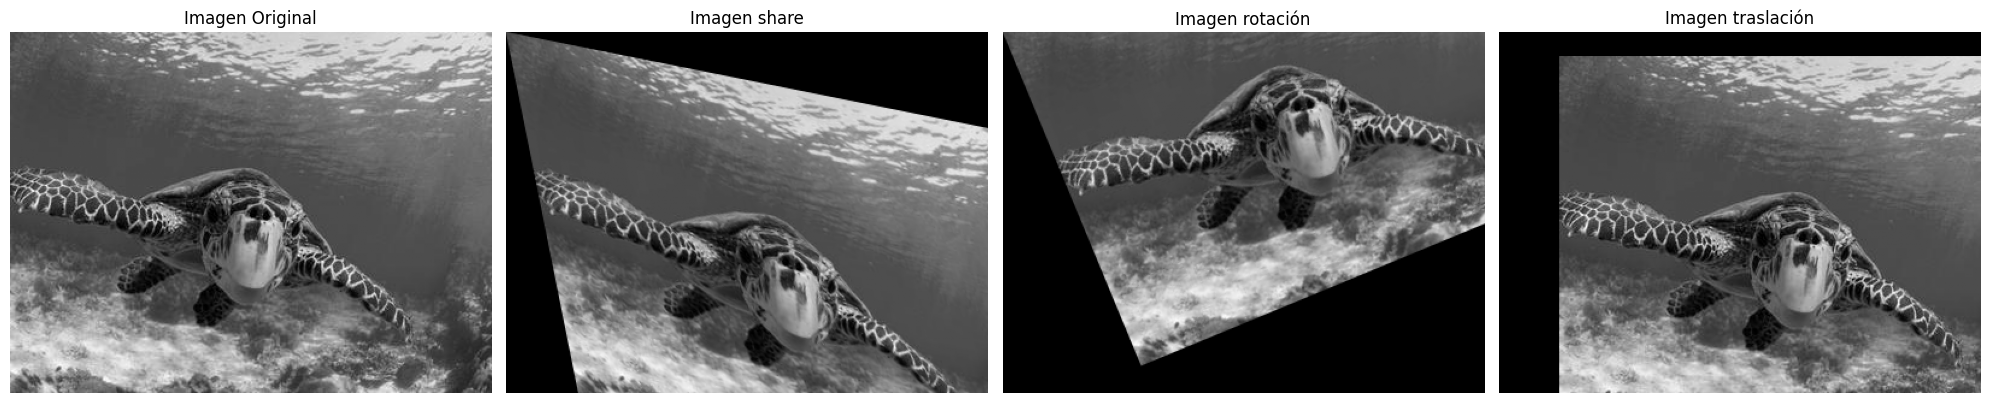

In [44]:
original_image = imread('turtle.jpg', as_gray = True)

# Definimos la matriz de transformación para el factor de shear
T_shear = np.array([[1, 0.2, 0], # factor de share horizontal
                [0.2, 1, 0], # factor de share vertical
                [0, 0, 1]]) 

# Definimos la matriz de transformación para la rotación de 45 grados
T_rot = np.array([[np.cos(-np.pi/8), -np.sin(-np.pi/8), 0], 
                  [np.sin(-np.pi/8), np.cos(-np.pi/8), 0],
                  [0, 0, 1]])

# Definimos la matriz de transformación para la translación
T_tras = np.array([[1, 0, 50], # desplazamiento en x
                  [0, 1, 20]],dtype= np.float32) # desplazamiento en y

# Aplicamos la transformación de shear a la imagen original
img_shear = cv2.warpPerspective(original_image, T_shear, (original_image.shape[1], original_image.shape[0]))

# Aplicamos la transformación de rotación a la imagen original
img_rot = cv2.warpPerspective(original_image, T_rot, (original_image.shape[1], original_image.shape[0]))

# Aplicamos la transformación de translación a la imagen original
img_tras = cv2.warpAffine(original_image, T_tras, (original_image.shape[1], original_image.shape[0]))

plt.figure(figsize=(20,8))

plt.subplot(141)
plt.title('Imagen Original')
plt.imshow(original_image, cmap = 'gray')
plt.axis('off')

plt.subplot(142)
plt.title('Imagen share')
plt.imshow(img_shear, cmap = 'gray')
plt.axis('off')

plt.subplot(143)
plt.title('Imagen rotación')
plt.imshow(img_rot, cmap = 'gray')
plt.axis('off')

plt.subplot(144)
plt.title('Imagen traslación')
plt.imshow(img_tras, cmap = 'gray')
plt.axis('off')

plt.tight_layout()

## Transformaciones de intensidad

Las *transformaciones de intensidad* consisten en aplicar una función a las intensidades de los píxeles de una imagen, de tal forma que estas varíen dentro del rango delimitado por su representación discreta propia. Si bien estas transformaciones pueden ser usadas como una forma de aumento de datos, teniendo en cuenta que permiten variar propiedades de la imagen como su contraste y realzar algunas intensidades de interés también se usa para mejorar la calidad de la imagen para una aplicación en específico. En esta sección desarrollaremos una función que nos permita realizar transformaciones exponenciales y de calibración de contraste. Las transformaciones de intensidad se pueden visualizar mediante una función que tiene como variable independiente las intensidades originales y como variable dependiente las intensidades de salida en el rango definido por la representación discreta de la imagen. Particularmente, la visualización de las transformaciones exponenciales y de calibración de contraste corresponden a las siguientes gráficas:

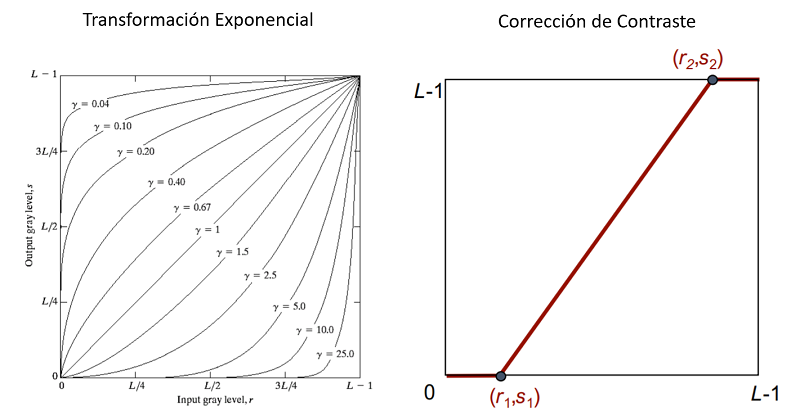

Para formular correctamente las funciones asociadas a estas transformaciones debemos comprender la representación de la imagen a trabajar. En esta ocasión trabajaremos con la imagen de un lago:

In [45]:
original_image = imread('lake.jpg', as_gray = True)
print('La intensidad mínima de la imagen es: ' + str(np.min(original_image)))
print('La intensidad máxima de la imagen es: ' + str(np.max(original_image)))

La intensidad mínima de la imagen es: 0.0
La intensidad máxima de la imagen es: 1.0


Al cargar las imágenes mediante la función `skimage.io.imread` con el parámetro `as_gray = True`, estas son representadas por arreglos de dos dimensiones para los cuales cada intensidad se encuentra normalizada entre 0 y 1. Podemos pasar a una representación de 8 bits (256 niveles de intensidad discretos asociados a números enteros) multiplicando estos arreglos por 255 y pasando de representación de punto flotante a entero:

In [46]:
original_image = (original_image * 255).astype(int)
print("Las intensidades del nuevo arreglo en representación de 8 bits son:")
np.unique(original_image)

Las intensidades del nuevo arreglo en representación de 8 bits son:


array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  26,
        28,  29,  30,  31,  32,  34,  35,  36,  38,  39,  40,  41,  42,
        43,  44,  45,  46,  47,  48,  49,  51,  52,  53,  55,  56,  58,
        59,  60,  62,  63,  64,  65,  67,  68,  69,  70,  71,  72,  73,
        75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,
        88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  99, 101, 102,
       103, 104, 105, 107, 109, 110, 112, 113, 115, 116, 117, 118, 119,
       120, 121, 123, 124, 125, 126, 127, 128, 129, 130, 131, 133, 134,
       135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
       149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161,
       162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174,
       175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187,
       188, 189, 190, 191, 192, 193, 195, 197, 198, 199, 201, 20

La transformación exponencial está dada por la siguiente función:
\begin{equation}
s = c r^{\gamma}
\end{equation}
donde $r$ es la intensidad original, $s$ es la intensidad resultante y $c$ y $\gamma$ son constantes positivas. La constante $c$ se elige de tal forma que la intensidad más alta de la representación permanezca invariante para un $\gamma$ ingresado como parámetro:
\begin{equation}
r_{max} = r_{max}^{\gamma - 1}
\end{equation}

In [47]:
def exponential_transform(image, gamma):
    c=(1/255)**(gamma - 1)
    transformed_image = np.round(c * image ** gamma,0).astype('int')
    return transformed_image

In [48]:
exponential_transform_image = exponential_transform(original_image,2)

assert np.max(exponential_transform_image)<=255, 'El maximo del resultado no debe ser mayor a 255'
assert exponential_transform_image.dtype == int, 'Las intensidades luego de la transformación deberían seguir siendo int'
assert np.isclose(np.sum(exponential_transform_image),22395794,0.1), 'No realizó el proceso de manera correcta'

El siguiente fragmento de código realiza una visualización de nuestra imagen original junto con transformaciones con $\gamma < 1$ y $\gamma > 1$:

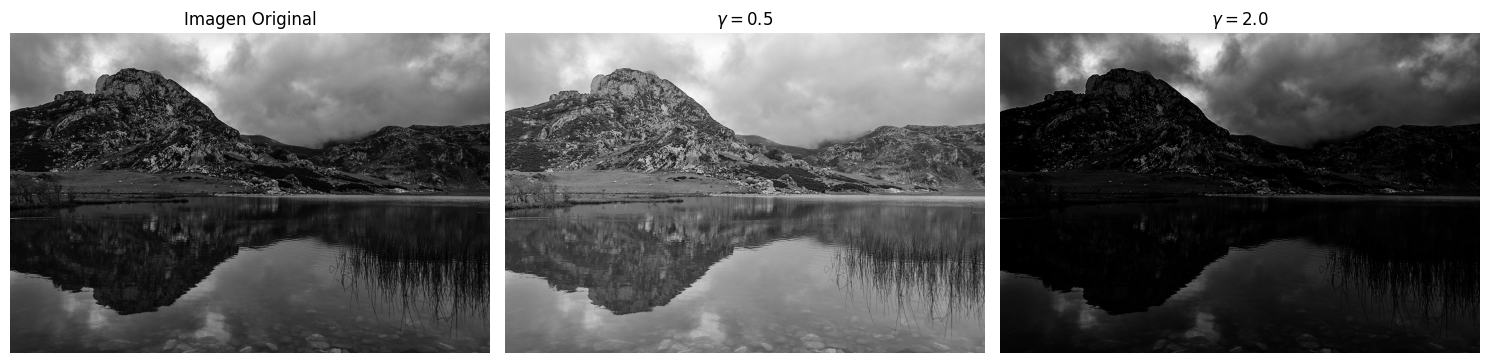

In [49]:
plt.figure(figsize=(15,8))

plt.subplot(131)
plt.title('Imagen Original')
plt.imshow(original_image, cmap = 'gray')
plt.axis('Off')

plt.subplot(132)
plt.title(r'$\gamma = 0.5$')
plt.imshow(exponential_transform(original_image, 0.5), cmap = 'gray')
plt.axis('Off')

plt.subplot(133)
plt.title(r'$\gamma = 2.0$')
plt.imshow(exponential_transform(original_image, 2.0), cmap = 'gray')
plt.axis('Off')

plt.tight_layout()

Cuál es la diferencia entre aplicar una transformación exponencial con $\gamma < 1$ y $\gamma > 1$? La diferencia está en la intensidad del gris en la imagen. Como observamos, cuando se tiene un $\gamma < 1$ la imagen se ve un poco más clara. Por otro lado, con un $\gamma$ más alto, la imagen se ve mucho más oscura.

La transformación de corrección de contraste es un caso particular de una transformación lineal definida a trozos. En ella, las intensidades menores a $r_1$ se umbralizan a la menor intensidad de la representación ($s_1$), y los valores mayores a $r_2$ se umbralizan a la mayor intensidad de la representación ($s_2$). 

In [50]:
def contrast_correction(image, r1, r2):
    
    transformed_image = np.zeros(image.shape)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            # Cuando la intensidad es menor al primer umbral, se mapea a la menor intensidad posible
            if image[i, j] < r1:
                transformed_image[i, j] = 0
            # Cuando la intensidad se encuentra entre ambos umbrales, se mapea según una función lineal
            elif r1 < image[i, j] < r2:
                transformed_image[i, j] = 255 * (image[i, j] - r1) / (r2 - r1)
            # Cuando la intensidad es mayor al segundo umbral, se mapea a la mayor intensidad posible
            else:
                transformed_image[i, j] = 255
    
    return transformed_image

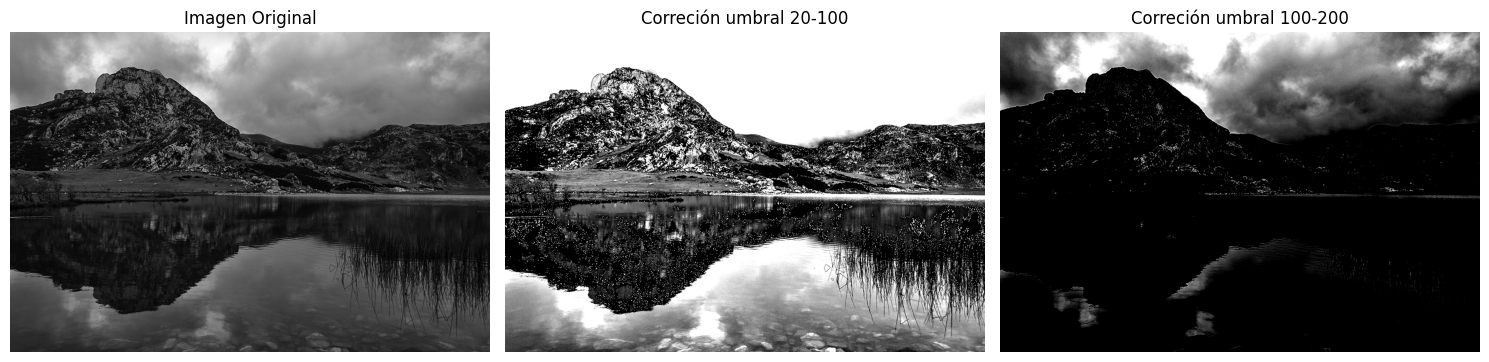

In [51]:
plt.figure(figsize=(15,8))

original_image = imread('lake.jpg', as_gray = True)
original_image = (original_image * 255).astype(int)
plt.subplot(131)
plt.title('Imagen Original')
plt.imshow(original_image, cmap = 'gray')
plt.axis('Off')

plt.subplot(132)
plt.title('Correción umbral 20-100')
plt.imshow(contrast_correction(original_image, 20,100), cmap = 'gray')
plt.axis('Off')

plt.subplot(133)
plt.title('Correción umbral 100-200')
plt.imshow(contrast_correction(original_image, 100,200), cmap = 'gray')
plt.axis('Off')

plt.tight_layout()

Finalmente, vamos a implementar de forma general las transformaciones definidas a trozos.

## Ejercicio 2:
Implemente una función definida a trozos. Tenga en cuenta que a la función le entrará la imagen y dos tuplas que contendran los valores (r1, s1) y (r2, s2).
> - Para esta función hay que verificar que los valores no superan los valores normales. Por ejemplo, r1 no debería ser mayor a 255. Para esos casos devuelva la misma imagen.
> - Además, tampoco podemos permitir que el valor de r1 sea mayor a r2 ni que s1 sea mayor a s2.

![imagen](transformacion.png)

In [64]:
def transformation(image, r1_s1, r2_s2):
    r1, s1 = r1_s1
    r2, s2 = r2_s2

    if r1 > 255 or s1 > 255 or r2 > 255 or s2 > 255:
        return image
    if r1 > r2 or s1 > s2:
        return image

    result = image.astype(float)
    
    m1 = s1 / r1
    result[image <= r1] = m1 * image[image <= r1]
    
    m2 = (s2 - s1) / (r2 - r1)
    result[(image > r1) & (image <= r2)] = s1 + m2 * (image[(image > r1) & (image <= r2)] - r1)

    m3 = (255 - s2) / (255 - r2)
    result[image > r2] = s2 + m3 * (image[image > r2] - r2)
    
    result = np.clip(result, 0, 255).astype(np.uint8)

    return result

(np.float64(-0.5), np.float64(999.5), np.float64(666.5), np.float64(-0.5))

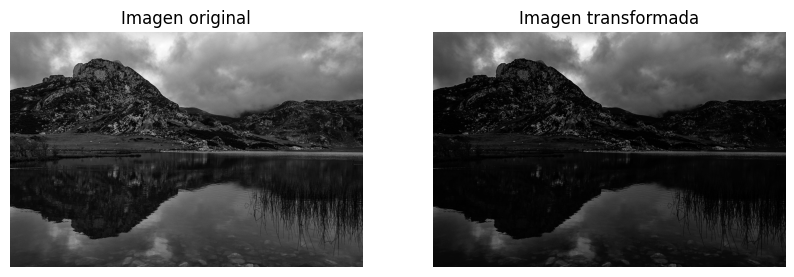

In [65]:
transformed_images = transformation(original_image, (50, 12), (200, 150))

assert np.isclose(np.sum(original_image - transformation(original_image, (129, 64), (128, 256))), 0), "Si un valor es mayor a 255 debería retornarse la misma imagen"
assert np.isclose(np.sum(original_image - transformation(original_image, (64, 64), (128, 256))), 0), "Si un valor es mayor a 255 debería retornarse la misma imagen"
assert np.isclose(np.sum(transformed_images), 27557380, 0.01), "La imagen no fue transformada correctamente"
assert np.isclose(np.sum(original_image - transformation(original_image, (64, 64), (128, 128))), 0), "La imagen no fue transformada correctamente"

plt.figure(figsize = (10, 10))

plt.subplot(121)
plt.imshow(original_image, cmap = 'gray')
plt.title("Imagen original")
plt.axis('off')

plt.subplot(122)
plt.imshow(transformed_images, cmap = 'gray')
plt.title("Imagen transformada")
plt.axis('off')

## Créditos ##

Danniel Moreno - Santiago Usma - Jose Miguel Abril Nova - Juan Camilo Lyons Bustamante - Felipe Escallón Páez - Jose Miguel Abril Nova - Javier Santiago Vera Rincon